## Import main functions

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_dataset')

In [0]:
import numpy as np

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
import umap

In [0]:
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, PReLU
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

In [0]:
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 3
RS = 2211

In [0]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [0]:
from sklearn.manifold import TSNE
import umap
import cv2 

In [0]:
encoder = load_model("/content/gdrive/My Drive/l4_dataset/encoder_balanced_weights.h5")

In [0]:
encoder.summary()

In [0]:
classifier = Sequential()
classifier.add(encoder)
classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(1, activation='linear', kernel_constraint=tensorflow.keras.constraints.NonNeg()))

In [0]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(learning_rate=0.005)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001, verbose=1)
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss")

classifier.compile(loss='mean_squared_error',
              optimizer='adam')

## Helper functions

In [0]:
def low_clip(x):
    x[x<=255] = 0
    return x

def minmax(x):
    if x.min() == x.max():
        return x
    return (x-x.min())/(x.max()-x.min())

def is_faulty(x):
  if x.max() <= 255:
    return True
  return False

In [0]:
def get_label(filename):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: empty/faulty

    # filename format: folder/CKX - L - 00(...)
    file = filename.split("/")[-1].split("(")[0]

    # get letter for DMSO indices
    letter = file.split('-')[1].strip()

    # get number
    number = file[-2:].strip()

    # get plate layout number
    ck = file[:4]

    # DMSO = []

    if ck == "CK19":
        #if number in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
        #   DMSO.append(len(labels))
        if number in ["3", "4", "5", "6", "7", "8", "24"]:
            label = 0
        elif number in ["9", "10", "11", "13", "14", "15", "23"]:
            label = 1
        elif number in ["16", "17", "18", "19", "20", "21", "22"]:
            label = 2
        else:
            label = 3
    elif ck == "CK21" or ck == "CK22":
        if number in ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]:
            label = 0
        elif int(number) in range(14, 24):
            label = 2
        else:
            label = 3
        #if label != 3 and letter in ["H", "P"]:
        #    DMSO.append(len(labels))
    else:
        print("No CK found")
        return False

    return label
  
def efficient_shuffle(*arrays, random_state=None):
    if not random_state:
        random_state = np.random.randint(0, 2211)
    for arr in arrays:
        np.random.seed(random_state)
        np.random.shuffle(arr)

In [0]:
def show_image(img, title="untitled", cmap="gray", **kwargs):
    try:
        plt.imshow(img, cmap=cmap, **kwargs)
    except:
        plt.imshow(img[:, :, 0], cmap=cmap, **kwargs)
    plt.axis("off")
    plt.title(title)

def reshape(img, w=imw, h=imh, c=c):
    if c > 1:
      return np.reshape(img, (w, h, c))
    else:
      return np.reshape(img, (w, h))

In [0]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    above_threshold = a >= val
    under_threshold = a < val
    a[above_threshold] = 1
    a[under_threshold] = 0
    return a.astype(np.uint8).reshape(int(np.sqrt(len(a))), int(np.sqrt(len(a))))

# For 500 images:
# CPU times: user 21 s, sys: 37.7 ms, total: 21 s
# Wall time: 5.49 s
def get_mask(img):
    # if image is all black: ignore
    if not img.any():
        return img.astype(np.uint8)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return convert_to_binary(center[label])

# For 500 images
# CPU times: user 180 ms, sys: 2 µs, total: 180 ms
# Wall time: 181 ms
def threshold(x):
    mask = np.copy(x)
    mask = mask.ravel()
    above_threshold = mask > x.mean()+x.std()
    under_threshold = mask <= x.mean() + x.std()
    mask[above_threshold] = 1
    mask[under_threshold] = 0
    return mask.astype(np.uint8).reshape((x.shape))

# intersection over union (evaluation function)
def iou(a,b):
    i = a&b
    u = a|b
    if u.sum() == 0:
        return 0
    return i.sum()/u.sum()

In [0]:
def plot_range(imgs, rn=8):
  fig = plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    ax = fig.add_subplot(1, 5, i)
    plt.imshow(imgs[i+rn])
    ax.axis('off')

In [0]:
def plot_clusters(X, y, labels=["Unstimulated", "OVA", "ConA", "Faulty"]):
    targets = range(len(labels))
    palette = np.array(sns.color_palette("hls", len(labels)))

    y = np.array(y)

    fig = plt.figure()
    ax = plt.subplot()

    for target, color, label in zip(targets, palette, labels):
        plt.scatter(X[y==target, 0], X[y==target, 1], c=[color], label=label, alpha=0.75, s=10)

    ax.axis('off')
    ax.grid(False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

## Read data

In [0]:
npzfile = np.load('/content/gdrive/My Drive/l4_dataset/CK19_full.npz')

In [0]:
metrics = np.load('/content/gdrive/My Drive/l4_dataset/CK19_calculated_metrics.npz')

In [0]:
X = npzfile['x']
filenames = npzfile['y']
y = np.array([get_label(i) for i in filenames])

In [0]:
labels = metrics['labels']
calculated_overlaps = metrics['calculated']

## Process images into dataset

In [0]:
def preprocess_no_labels(data, labels, filenames, mask=False):
    data = np.copy(data)
    l = len(data)
    # initialise arrays for filling in
    x_data = np.ndarray(shape=(l // 2, 192, 192, 3), dtype=np.float32)

    # initialise index values
    idx = 0
    i = 0
    count = 0

    # loop through images and process
    while idx < l-100:
        # ignore 100, 300, etc. values as they will already have been processed
        if count == 100:
            count = 0
            idx += 100
        else:
            # if the image is "faulty" we cannot low_clip and apply minmax -> NaN
            if is_faulty(data[idx]) or is_faulty(data[idx + 100]):
                x_data[i, ..., 1] = minmax(data[idx])
                x_data[i, ..., 0] = minmax(data[idx + 100])
                labels[i] = get_label(filenames[idx])
            else:
                x_data[i, ..., 1] = minmax(low_clip(data[idx]))
                x_data[i, ..., 0] = minmax(low_clip(data[idx + 100]))
            
            # mask out the background
            if mask:
                x_data[i, ..., 0] *= get_mask(x_data[i, ..., 0])  # red-coloured
                x_data[i, ..., 1] *= get_mask(x_data[i, ..., 1])  # green-coloured

            # try and save memory
            data[idx] = 0
            data[idx+100] = 0

            idx += 1
            i += 1
            count += 1

    print('Images preprocessed. Size of dataset: {}'.format(len(x_data)))
    return x_data, labels

In [0]:
x_combined, y_labels = preprocess_no_labels(X, labels, filenames)

Images preprocessed. Size of dataset: 29400


In [0]:
y_combined = calculated_overlaps

In [0]:
X = None

In [0]:
efficient_shuffle(x_combined, y_combined, y_labels, filenames, random_state=RS)

## Interaction classifier (quantity)

In [0]:
x_train, x_test, y_train, y_test = x_combined[:-10000], x_combined[-10000:], y_combined[:-10000], y_combined[-10000:]

In [0]:
history = classifier.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
          validation_split=0.15,
          callbacks=[reduce_lr, early_stop]
          )

Train on 16490 samples, validate on 2910 samples
Epoch 1/20
16490/16490 [==============================] - 97s 6ms/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 2/20
16490/16490 [==============================] - 95s 6ms/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 3/20
16490/16490 [==============================] - 95s 6ms/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 4/20
16490/16490 [==============================] - 95s 6ms/sample - loss: 9.9104e-04 - val_loss: 8.6729e-04
Epoch 5/20
16490/16490 [==============================] - 95s 6ms/sample - loss: 6.9954e-04 - val_loss: 8.6314e-04
Epoch 6/20
16490/16490 [==============================] - 95s 6ms/sample - loss: 5.8634e-04 - val_loss: 8.0694e-04
Epoch 7/20
16448/16490 [============================>.] - ETA: 0s - loss: 4.8139e-04
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
16490/16490 [==============================] - 96s 6ms/sample - loss: 4.8090e-04 - val_loss: 8.3128e-04


In [0]:
classifier.save("/content/gdrive/My Drive/l4_dataset/regression_balanced_weights.h5")

## Evaluating the regression model (plots and metrics)

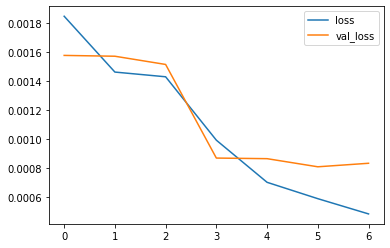

In [0]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [0]:
predictions = classifier.predict(x_test)

In [0]:
def plot_predictions_histogram(x_true, x_pred, y):
    t_u = x_true[y==0].flatten() # true unstimulated
    t_o = x_true[y==1].flatten() # true ova
    t_c = x_true[y==2].flatten() # true cona 

    p_u = x_pred[y==0].flatten() # predicted unstimulated
    p_o = x_pred[y==1].flatten() # predicted ova
    p_c = x_pred[y==2].flatten() # predicted cona 

    p_palette = np.array(sns.color_palette("hls", 4))[:3]
    t_palette = np.array(["red", "green", "blue"])

    fig = plt.figure(figsize=(10,5))
    ax1 = plt.subplot(211)

    plt.hist([p_u, p_o, p_c], bins=32,
         label=["Unstimulated", "OVA", "ConA"],
         color=p_palette)
    
    plt.title("Histograms for predicted vs true overlaps")
    plt.legend()

    ax2=plt.subplot(212, sharex=ax1, sharey=ax1)
    plt.hist([t_u, t_o, t_c], bins=32,
         label=["Unstimulated", "OVA", "ConA"],
         color=p_palette)
    
    plt.xlabel("Level of interaction (Area of overlap)")
    plt.show()

def plot_lines_of_best_fit(x_true, x_pred, y):
    t_u = x_true[y==0].flatten() # true unstimulated
    t_o = x_true[y==1].flatten() # true ova
    t_c = x_true[y==2].flatten() # true cona 

    p_u = x_pred[y==0].flatten() # predicted unstimulated
    p_o = x_pred[y==1].flatten() # predicted ova
    p_c = x_pred[y==2].flatten() # predicted cona 

    p_palette = np.array(sns.color_palette("hls", 4))[:3]

    fig = plt.figure(figsize=(16,16))
    s1 = plt.subplot(131, aspect='equal')
    s1.scatter(t_u, p_u, c=[palette[0]], alpha=0.65, lw=0.1, edgecolor='k')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    s1.plot(t_u, p_u, 'red')
    plt.title("Predictions - Unstimulated label")

    s2 = plt.subplot(132, aspect='equal')
    s2.scatter(t_o, p_o, c=[palette[1]], alpha=0.65, lw=0.1, edgecolor='k')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    s2.plot(t_o, t_o, 'green')
    plt.title("Predictions - OVA label")

    s3 = plt.subplot(133, aspect='equal')
    s3.scatter(t_c, p_c, c=[palette[2]], alpha=0.65, lw=0.1, edgecolor='k')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    s3.plot(t_c, t_c, 'blue')
    plt.title("Predictions - ConA label")

    plt.tight_layout()
    plt.show()

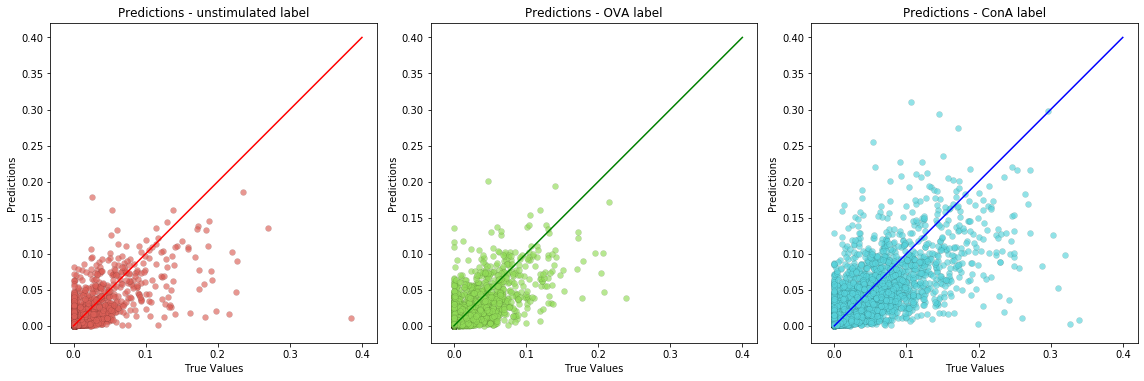

In [0]:
plot_scatter(y_test, predictions, y_labels[-10000:])

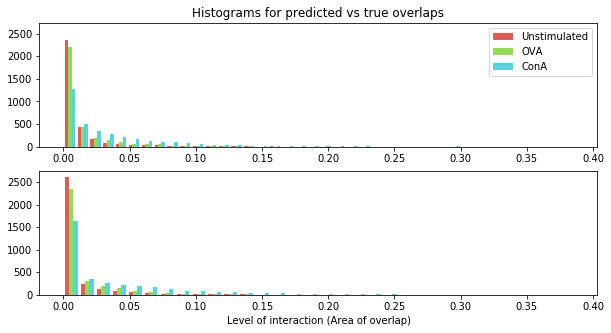

In [0]:
plot_histogram(y_test, predictions, y_labels[-10000:])

In [0]:
def plot_error_distribution(y_true, y_pred):
    error = y_pred - y_true
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Error distribution")
    plt.show()

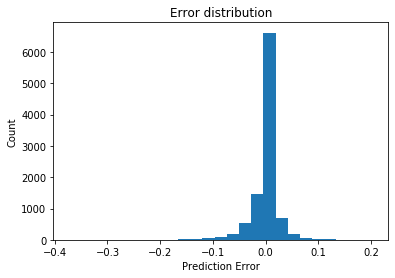

In [0]:
plot_error_distribution(y_test, predictions)

In [0]:
from sklearn.metrics import mean_squared_error

# https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019
def r2_score(y_true, y_pred):
    ssres = np.sum(np.square(y_true - y_pred))
    sstot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - ssres / sstot

def metrics_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print("MSE score: {} -- this is the average square difference between true and predicted".format(mse))
    print("RMSE score: {} -- difference between T and P in DV unit".format(rmse))
    print("R2 score: {} -- explains variance. closest to 1 is better".format(r2))

In [0]:
metrics_report(y_test, predictions)

MSE score: 0.0007079740753397346 -- this is the average square difference between true and predicted
RMSE score: 0.026607781648635864 -- difference between T and P in DV unit
R2 score: 0.5263136923313141 -- explains variance. closest to 1 is better


## Clustering with size of overlap

In [0]:
def plot_clusters_with_size(X, y, s, labels=["Unstimulated", "OVA", "ConA"]):
    targets = range(len(labels))
    shades = np.array(sns.color_palette("hls", 4))[:3]
    shades = ["red", "LimeGreen", "deepskyblue"]

    y = np.array(y)

    fig = plt.figure(figsize=(15,15))
    ax = plt.subplot()

    palette = [sns.light_palette(i, as_cmap=True) for i in shades]

    for target, color, label in zip(targets, palette, labels):
        sc = plt.scatter(X[y==target, 0], X[y==target, 1], c=s[y==target].flatten(), cmap=color, s=(s[y==target]+0.01)*500, label=label, alpha=0.95, edgecolor="k", lw=0.2)

    ax.axis('off')
    ax.grid(False)

    plt.show()

In [0]:
encoded_imgs = encoder.predict(x_test)

In [0]:
import umap

In [0]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded_imgs)

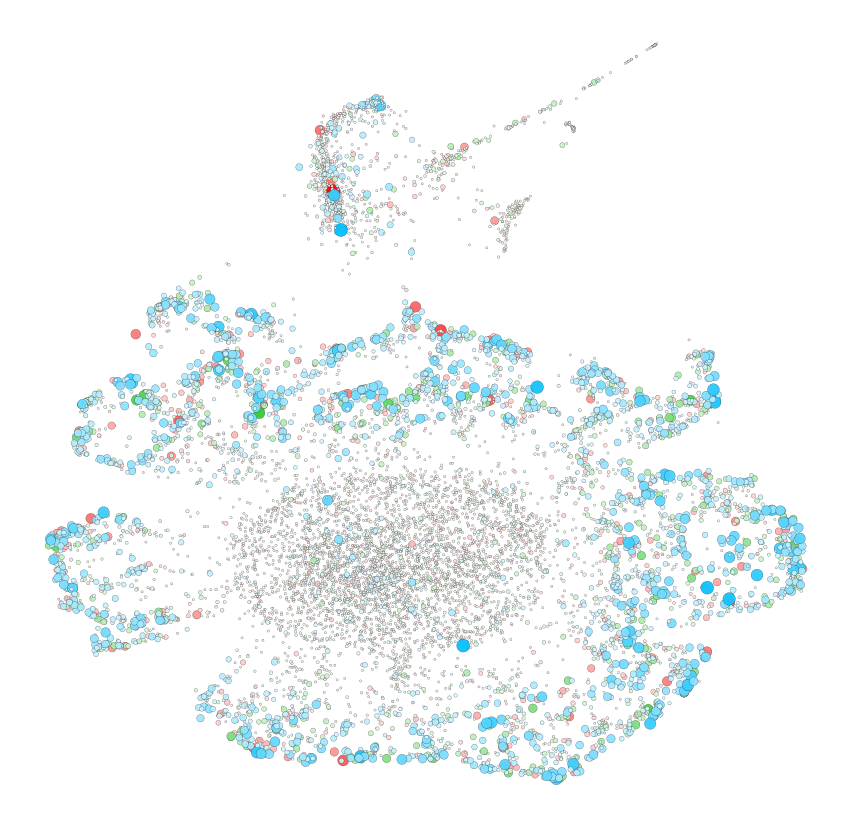

In [0]:
plot_clusters_with_size(x_umap, y_labels[-10000:], y_test)

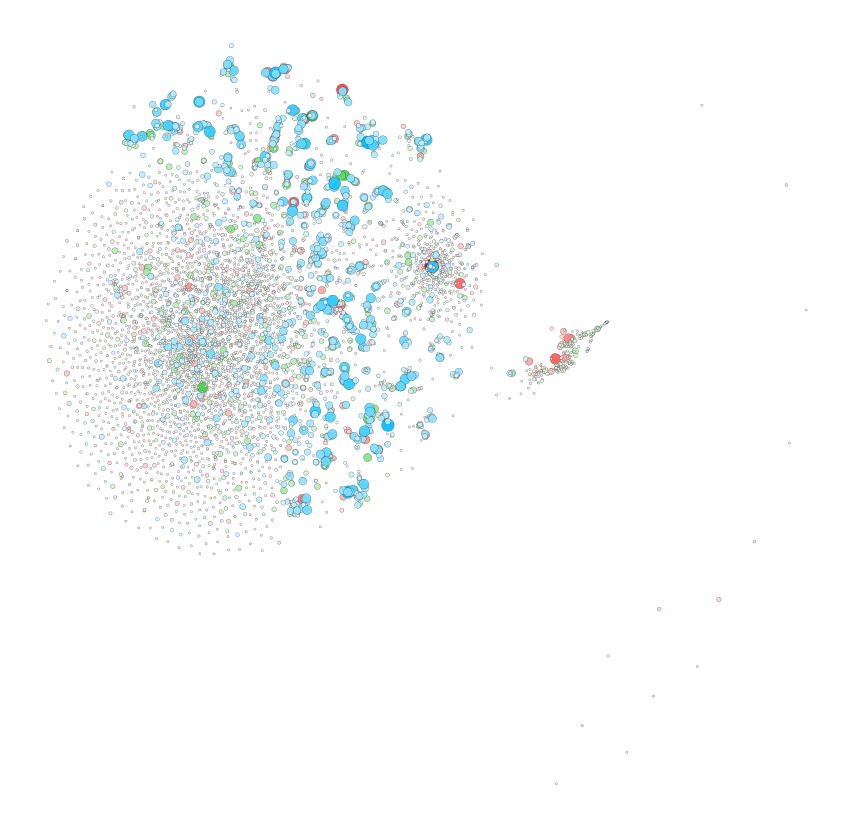

In [0]:
plot_clusters_with_size(x_tsne, labels_test, y_test)

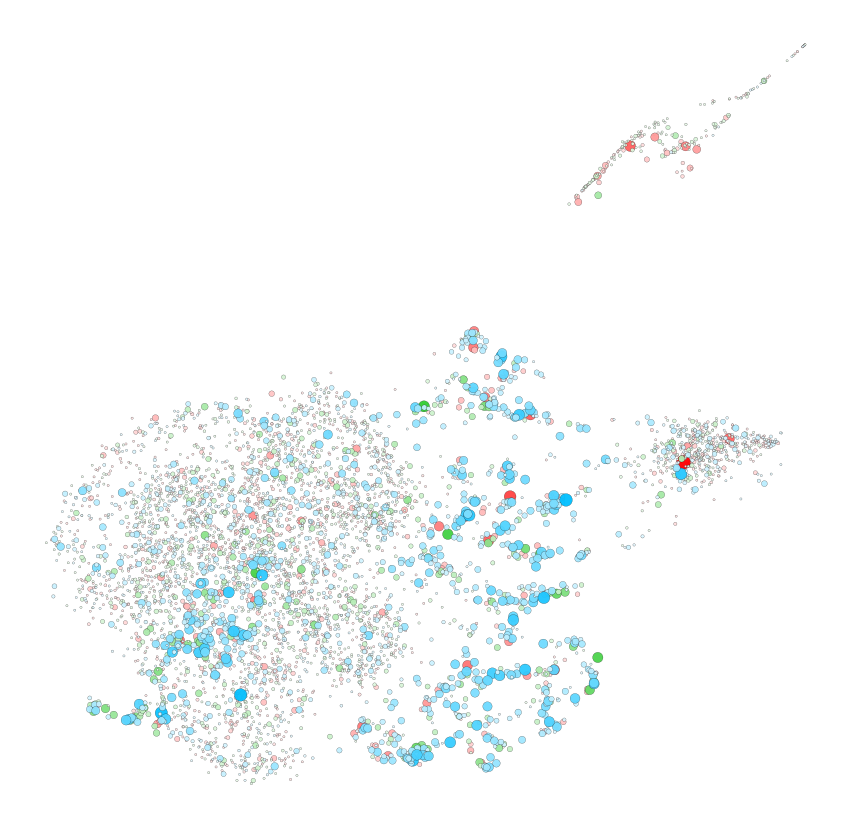

In [0]:
plot_clusters_with_size(x_umap, labels_test, y_test)

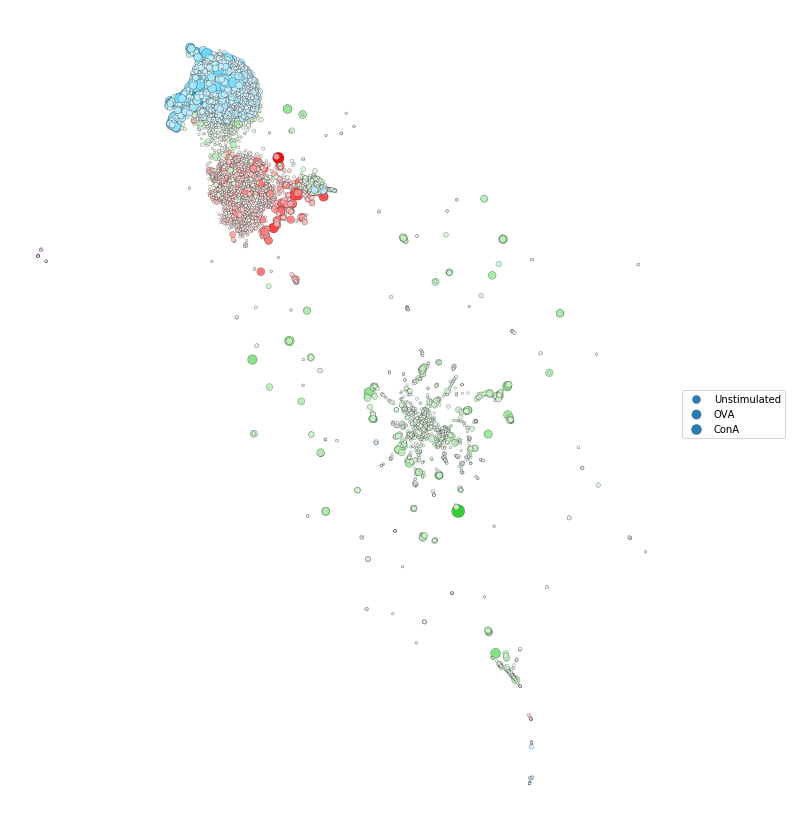

In [0]:
plot_clusters_with_size(x_umap, test_labels, predictions)

## Label classifier (unstimulated, ova, cona, faulty)

```python
classifier = Sequential()
classifier.add(encoder)
classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(4, activation='softmax'))
```

In [0]:
x_train, x_test, y_train, y_test = x_combined[:-1000], x_combined[-1000:], y_combined[:-1000], y_combined[-1000:]

In [0]:
len(x_train), len(x_test)

(27600, 1000)

In [0]:
y_train_c = tensorflow.keras.utils.to_categorical(y_train, 4)

In [0]:
y_test_c = tensorflow.keras.utils.to_categorical(y_test, 4)

In [0]:
history = classifier.fit(x_train, y_train_c,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_split=0.15)

Train on 23460 samples, validate on 4140 samples
Epoch 1/10
23460/23460 [==============================] - 45s 2ms/sample - loss: 0.9583 - acc: 0.5219 - val_loss: 0.9563 - val_acc: 0.5435
Epoch 2/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.8078 - acc: 0.6246 - val_loss: 0.8666 - val_acc: 0.5966
Epoch 3/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.7386 - acc: 0.6659 - val_loss: 0.9142 - val_acc: 0.5865
Epoch 4/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.6689 - acc: 0.7057 - val_loss: 0.9046 - val_acc: 0.5937
Epoch 5/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.6012 - acc: 0.7447 - val_loss: 0.9511 - val_acc: 0.5845
Epoch 6/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.4663 - acc: 0.8087 - val_loss: 1.0370 - val_acc: 0.5906
Epoch 7/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.3313 - acc: 0.8766 - val_loss: 1.2

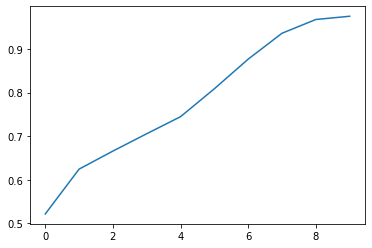

In [0]:
plt.plot(history.history['acc'])

In [0]:
score1 = classifier.evaluate(x_test, y_test_c, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 2.2097943849563597
Test accuracy: 0.528


In [0]:
y_pred = np.argmax(classifier.predict(x_test), axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

names = ["Unstimulated", "OVA", "ConA", "Faulty"]

def plot_confusion_matrix(predictions, labels):
  plt.figure(figsize=(12,10))
  cm = confusion_matrix(labels, predictions)
  ax = sn.heatmap(cm, fmt="d", annot=True, cmap="Greens", cbar_kws={'label': 'Number of predictions'}, 
             xticklabels=names, yticklabels=names)
  ax.set_ylabel("True label")
  ax.set_xlabel("Predicted label")

In [0]:
np.sum(y_test[y_test==1])

21.0

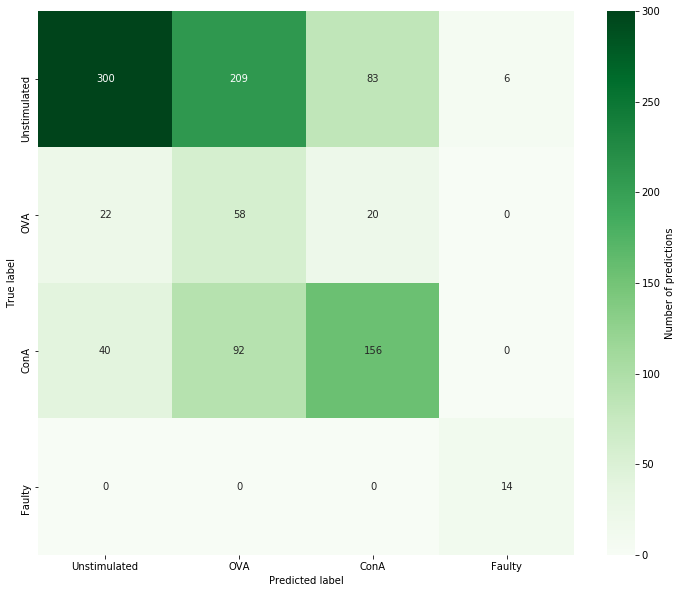

In [0]:
plot_confusion_matrix(y_pred, y_test)